<img src="https://www.strath.ac.uk/media/1newwebsite/webteam/logos/xUoS_Logo_Horizontal.png.pagespeed.ic.M6gv_BmDx1.png" width="350" align="left" style="left">

# 2. Machine Learning-Based Classification

## Introduction

In machine learning, classification is typically considered a supervised learning task - meaning that we provide a model with data $x$ and desired responses (labels) $y$, and it uses these to fit a function to best map these inputs $x$ to the desired outputs $y$ during training. An example of supervised learning is logistic regression, which we will be implementing to classify our modulated signals.

In this notebook we will cover simple machine learning algorithms, suchs as binary and multiclass Logistic Regression, and how to train them to classify our modulation schemes from generated data.

## Table of Contents

* [2.1 Logistic Regression](#logistic_regression)
* [2.2 Generating Training Data](#train_data)
* [2.3 Gradient Descent](#sgd)
* [2.4 Multiclass Logistic Regression](#multiclass)
* [2.5 Conclusion](#conclusion)
    
Throughout this notebook we will only be using Numpy and Matplotlib to define and train the classifiers. Once you understand the basics you can always leverage specialized machine learning libraries, such as scikit-learn, where a lot of the nitty gritty can be abstracted away.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

For convenience we wrapped the data generation and statistics calculating functions from the previous notebook into the helper_functions module, which means we have to import them to be able to generate data for classification again.

In [2]:
from pystrath_sdr.helper_functions import awgn, generate_bpsk, generate_qpsk, generate_qam, generate_ask4, to_onehot, calculate_statistics

We will be using the same data and class labels as in the previous notebook.

In [3]:
classes = {0: 'BPSK', 1:'QPSK', 2:'16-QAM', 3:'4-ASK'}

## 2.1 Logistic Regression <a class="anchor" id="logistic_regression"></a>

Binary Logistic Regression is one of the simplest classification algorithms used today - while it may sound similar to linear regression, which is used for curve fitting, logistic regression works on a similar principle with the difference being we try to fit a boundary between two classes. Given our training data $\{x,y\}$ we try to fit a hypothesis function $h$ so that $y = h(x,w)$, where $w$ are the feature weights that it needs to learn. If we took our decision tree as an example, we were hard coding weightings for different features, this time we will try to learn them by training a logistic regression model.

The logistic regression forward pass is defined as

$\hat{y} = g(xw + b)$

where $x$ is our input vector, $\hat{y}$ is the model prediction (or approximation of the $y$ label), $w$ represents the learned weights and $b$ is an added bias term, which is also learned along with the weights. g(.) is an activation function adding some non-linearity to our model. Typically for logistic regression it is the sigmoid function, defined as:

$g(x) = \frac{1}{1-e^{-x}}$

In [4]:
def sigmoid(y):
    return 1/(1+np.exp(-y))

What the sigmoid function does is squash our input into the range of $\in{(0,1)}$, where 0 is a negative and 1 is a positive classification.

Text(0.5, 1.0, 'Sigmoid Activation Function')

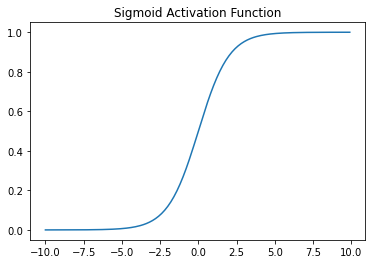

In [5]:
x = np.arange(-10,10,0.1)
plt.plot(x,sigmoid(x))
plt.title('Sigmoid Activation Function')

Now we can define the forward pass of our logistic model. **A note on bias**: in some literature bias term $b$ is an extra term that is added in code as an additional variable to the weight vector, in others it is considered another weight, e.g. $w_{0}$. Mathematically these are equivalent - it just means that in the latter case we treat our first weight $w_0$ as the bias, since it gets multiplied by a constant value of 1 in the feature vector $x$.

$xw + b = \begin{bmatrix} x_0,  x_1,  x_2,  x_3,  x_4, x_5  \end{bmatrix} \begin{bmatrix} w_0 \\ w_1 \\ w_2 \\ w_3 \\ w_4 \\ w_5 \end{bmatrix} + b \equiv \begin{bmatrix} 1, x_0, x_1,  x_2,  x_3,  x_4,  x_5  \end{bmatrix} \begin{bmatrix} w_0 \\ w_1 \\ w_2 \\ w_3 \\ w_4 \\ w_5 \\ w_6 \end{bmatrix}$ , where $b=w_0$

For simplicity we will consider bias to be another weight to be learned, which means our weight vector will be (7,1), even though our number of features is 6. We can make the matrix multiplies work out by appending an additional 1 to our feature vector. 

In [6]:
def forward(x, weights):
    y = np.dot(x, weights) # weights
    z = sigmoid(y) # sigmoid activation
    return z

We also need a metric to tell our machine learning model how well it is doing, otherwise how will we know if it is learning? These metrics are usually referred to cost (or loss) functions. For logistic regression we use the log loss, as defined:

$Cost(y,\hat{y}) = \frac{1}{m}\sum^{m}_{i=0} y_{i} log(\hat{y_{i}}) + (1 - y_{i}) log(1 - \hat{y_{i}})$

where m is the number of examples, $y$ are the labels, and $\hat{y}$ are the model predictions. The cost will be high if our predictions are far from the labelled data, and low if all model predictions are correct.

In [7]:
def cost(x, y, w):
    y_hat = forward(x,w)
    cost = (np.matmul(-y.T, np.log(y_hat)) - np.matmul((1 -y.T), np.log(1 - y_hat)))/x.shape[0]
    return cost

## 2.2 Generating training data <a class="anchor" id="train_data"></a>

Simple logistic regression is a binary classifier, which means it can only discern between two classes. Here we will generate some training data and evaluate a binary BPSK vs QPSK classifier. Note that the shape of our training data is 7 columns wide, because we added an additional bias term of all ones.

In [8]:
bpsk_train = np.array([calculate_statistics(generate_bpsk(256,30)) for i in range(100)])
qpsk_train = np.array([calculate_statistics(generate_qpsk(256,30)) for i in range(100)])

x = np.concatenate((bpsk_train, qpsk_train))
x = np.concatenate((np.ones((200,1)),x),axis=1) # add bias
x.shape

(200, 7)

We also need to generate corresponding labels. We define BPSK as class 0, meaning we expect an output of 0 for a successful prediction, and QPSK the positive prediction with an output of 1.

In [9]:
bpsk_labels = np.zeros((100,1))
qpsk_labels = np.ones((100,1))
y = np.concatenate((bpsk_labels, qpsk_labels))
y.shape

(200, 1)

We perform weight initialization by filling up our weight vector with random values. We draw our weights from a normal distribution as we want to keep them small, which helps training - if we are unlucky large **wrong** initial weights can cause large errors, which would require many more gradient descent steps to correct the weights to more optimal values. Remember that we add an additional weight $w_0$ as our bias.

In [10]:
w = np.random.randn(7,1)

## 2.3 Gradient Descent <a class="anchor" id="sgd"></a>

Gradient descent is the bread and butter in the vast majority of machine learning algorithms. There are derivatives and other additions one can make, but at the heart of it is usually gradient descent. Here we use the basic version as defined by

$\Delta w = 1/m \sum^{m}_{i=0} x_{i} (h(x_{i},w) - y_{i})$

where $\Delta w$ is the gradient of our weights, $m$ is the number of training samples, $h$ represents our logistic regression hypothesis function and $y$ are our labels. We use the gradient to nudge our weights in the direction where the cost will be smaller, so that the next time our model sees the same data it can more accurately predict the output. 

The amount "nudging" is controlled by the learning rate $\alpha$, and we can define the rule for acquiring new weights per gradient descent iteration as:

$w = w - \alpha \Delta{w}$

In [11]:
def gradient_descent(x, y, w, lr):
    m = x.shape[0]
    h = forward(x, w)
    grad = np.matmul(x.T, (h - y)) / m;
    w = w - lr * grad
    return w

Now train our classifier for 200 iterations with a learning rate of $\alpha = 0.2$. You can try different number of iterations or values of $\alpha$ to see if you could make it learn faster or achieve a better result. Smaller learning rates result in slow and steady optimization towards a minimum cost however this usually comes at a tradeoff of requiring more gradient descent iterations. A larger learning rate may result in us converging to a good set of weights faster (fewer iterations), but there is a chance of overshooting the minimum or becoming unstable and not being able to learn at all!

In [12]:
alpha = 0.2
num_iter = 200

# predefine a list to store our computed cost after each iteration
costs = []

for i in range(num_iter):
    w = gradient_descent(x,y,w,alpha)
    costs.append(cost(x,y,w).squeeze())

We can see that our cost is going down as we train the model and update the weights, which is what we expect! If the cost was not going down, one of the things we could try to do is to readjust our learning rate.

Text(0, 0.5, 'Log Loss')

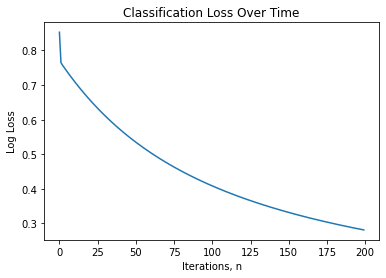

In [13]:
plt.plot(costs)
plt.title('Classification Loss Over Time')
plt.xlabel('Iterations, n')
plt.ylabel('Log Loss')

**Evaluate Binary Logistic Regression**

Now that we have the weights of logistic regression, we can define a new prediction function that would not require us to add a bias term to our data, but instead will just use the weight vector.

In [14]:
def predict(x,w):
    
    y = np.dot(x, w[1:]) + w[0] # w_0 is our bias
    z = 1/(1+np.exp(-y)) # sigmoid activation
    
    if z >= 0.5:
        return 1
    else:
        return 0

Let's generate a new QPSK waveform and see how our network would predict it.

In [15]:
new_data = calculate_statistics(awgn(generate_qpsk(256),30))
classes[predict(new_data,w)]

'QPSK'

So far so good! Now to extend this to a multiclass problem.

## 2.4 Multiclass Logistic Regression <a class="anchor" id="multiclass"></a>

Binary classification is great if we only have two modulation classes or whether we want to know if signal is present or isn't, etc. To replicate the functionality of our decision tree and scale to a larger number of modulation schemes we need to use multiclass logistic regression. This can be achieved by using one-vs-all training - meaning we create and train a binary classifier for each modulation scheme and train it to differentiate between that modulation scheme and all others bunched together into a single class.

Our new prediction function would look something like this:

$\hat{y}_i = \max\limits_{i} (g(xw_i + b))$

Where for each classifier $i$, we compute the output $\hat{y}_i$, and take the maximum response of the outputs. Another way of looking at this is we pick the classifier that is most confident in its answer.

**Generate training data**

We generate 500 examples (or frames) for each modulation scheme. Then concatenate the generated data for each modulation scheme into a single training dataset.

In [16]:
snr = 20 # train on slightly noisy data, so the resulting model is more robust to noise
num_examples = 500

# Generate data, and calculate stats vector for each mod scheme
bpsk_train = np.array([calculate_statistics(generate_bpsk(256,snr)) for i in range(num_examples)])
qpsk_train = np.array([calculate_statistics(generate_qpsk(256,snr)) for i in range(num_examples)])
qam_train = np.array([calculate_statistics(generate_qam(256,snr)) for i in range(num_examples)])
ask4_train = np.array([calculate_statistics(generate_ask4(256,snr)) for i in range(num_examples)])

# Concatenate into a single training dataset
x = np.concatenate((bpsk_train, qpsk_train, qam_train, ask4_train))
x = np.concatenate((np.ones((x.shape[0],1)),x),axis=1) # add bias
x.shape

(2000, 7)

Do the same for labels. Make sure that the number of training examples and labels matches.

In [17]:
# Labels for each modulation scheme, int8 so they stay integers for one-hot encoding
bpsk_labels = np.ones((bpsk_train.shape[0],), dtype=np.int8)*0
qpsk_labels = np.ones((qpsk_train.shape[0],), dtype=np.int8)*1
qam_labels = np.ones((qam_train.shape[0],), dtype=np.int8)*2
ask4_labels = np.ones((ask4_train.shape[0],), dtype=np.int8)*3

y = np.concatenate((bpsk_labels, qpsk_labels, qam_labels, ask4_labels))
y.shape

(2000,)

Next, since we cannot feed non-binary labels into our individual classifiers, we convert them to one-hot vectors, this allows us treat each column as the training labels for each individual classifier.

In [18]:
y_oh = to_onehot(y, num_classes=4)
print(y_oh.shape)
y_oh

(2000, 4)


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

**Main training loop**

Note that now we represent our model with a 3-dimensional weight vector $h$, where the first dimension is the number of classifiers we will loop over to make a predictions. We will perform the same gradient descent learning as we did for our binary classifier, but will do it in a loop for each of our 4 classifiers.

In [19]:
# Initialize weight matrix for 4 classifiers
h = np.random.randn(4,7,1)

# Set training parameters
num_iter = 500
alpha = 0.25

# Predefine array where we will store the cost values for each iteration
costs = np.zeros((num_iter,4))

# For each classifier
for i, w in enumerate(h):
    
    # Take ith column to make a new label vector
    y_ = np.expand_dims(y_oh[:,i],axis=1)

    # Train one binary classifier
    for n in range(num_iter):
        w = gradient_descent(x,y_,w,alpha) # do one gradient descent step
        costs[n,i] = cost(x,y_,w).squeeze() # add current cost value
    
    # add final weights to our array
    h[i] = w

Now we can plot the individual cost values over the number of iterations. Based on the figure, we can see that all classifiers are learning! Albeit some better than others - just looking at the costs we can see that QPSK will do worse than BPSK, at least in the 20dB range. This means that our training parameters are good enough, but we could certainly improve this by tuning the learning rate and number of iterations.

Text(0, 0.5, 'Log Loss')

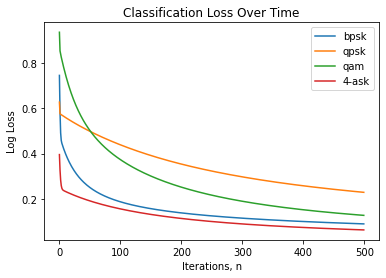

In [20]:
plt.plot(costs)
plt.legend(('bpsk', 'qpsk', 'qam', '4-ask'))
plt.title('Classification Loss Over Time')
plt.xlabel('Iterations, n')
plt.ylabel('Log Loss')

Now that we have trained all our classifiers, and their weights are defined in $h$, we can define a prediction function for the multiclass case.

In [21]:
def predict_multiclass(x,h):

    predictions = np.zeros(h.shape[0],)
    
    for i, w in enumerate(h):

        y = np.dot(x, w[1:]) + w[0] # weights
        predictions[i] = 1/(1+np.exp(-y)) # sigmoid activation

    return predictions

To test it, we can produce a QAM signal and see what the outputs would look like.

In [22]:
new_data = calculate_statistics(awgn(generate_qam(256),30))
predictions = predict_multiclass(new_data,h)
predictions

array([0.00331995, 0.11337123, 0.8811218 , 0.08068568])

The 3rd classifier is by far the most confident in its prediction, which confirms that it is indeed a 16-QAM signal.

In [23]:
classes[np.argmax(predictions)]

'16-QAM'

**Multiclass logistic regression accuracy evaluation**

Now we can evaluate our logistic regression classifier over an SNR range, just like the DT classifier that we hand-coded.

In [24]:
# Set test parameters
snrs = np.arange(0,25)
num_examples = 500 # number of frames per modulation scheme
num_symbols = 256 # symbols per frame

# Instantiate empty lists where accuracy results will be kept for plotting
bpsk_results, qpsk_results, qam_results, ask4_results = [], [], [], []

for i in range(len(snrs)):
    snr = snrs[i]
    
    # Generate all waveforms
    bpsk_data = np.array([generate_bpsk(num_symbols,snr) for i in range(num_examples)])
    qpsk_data = np.array([generate_qpsk(num_symbols,snr) for i in range(num_examples)])
    qam_data = np.array([generate_qam(num_symbols,snr) for i in range(num_examples)])
    ask4_data = np.array([generate_ask4(num_symbols,snr) for i in range(num_examples)])
    
    # Calculate accuracies
    bpsk_acc = np.mean([np.argmax(predict_multiclass(calculate_statistics(x),h))==0 for x in bpsk_data])*100
    qpsk_acc = np.mean([np.argmax(predict_multiclass(calculate_statistics(x),h))==1 for x in qpsk_data])*100
    qam_acc = np.mean([np.argmax(predict_multiclass(calculate_statistics(x),h))==2 for x in qam_data])*100
    ask4_acc = np.mean([np.argmax(predict_multiclass(calculate_statistics(x),h))==3 for x in ask4_data])*100
    
    # Save results for later plotting
    bpsk_results.append(bpsk_acc)
    qpsk_results.append(qpsk_acc)
    qam_results.append(qam_acc)
    ask4_results.append(ask4_acc)
    
    print('For SNR={}dB, BPSK: {:.2f}%, QPSK: {:.2f}, QAM-16: {:.2f}%, ASK-4: {:.2f}%'.format(snr, bpsk_acc, qpsk_acc, qam_acc, ask4_acc))

For SNR=0dB, BPSK: 27.20%, QPSK: 98.20, QAM-16: 0.00%, ASK-4: 0.00%
For SNR=1dB, BPSK: 33.20%, QPSK: 98.20, QAM-16: 0.00%, ASK-4: 0.00%
For SNR=2dB, BPSK: 40.20%, QPSK: 99.00, QAM-16: 0.00%, ASK-4: 0.20%
For SNR=3dB, BPSK: 57.80%, QPSK: 99.40, QAM-16: 0.00%, ASK-4: 0.00%
For SNR=4dB, BPSK: 85.20%, QPSK: 99.00, QAM-16: 0.00%, ASK-4: 0.80%
For SNR=5dB, BPSK: 96.60%, QPSK: 99.40, QAM-16: 0.00%, ASK-4: 0.20%
For SNR=6dB, BPSK: 99.80%, QPSK: 99.20, QAM-16: 0.00%, ASK-4: 0.20%
For SNR=7dB, BPSK: 99.80%, QPSK: 99.40, QAM-16: 1.60%, ASK-4: 4.20%
For SNR=8dB, BPSK: 100.00%, QPSK: 100.00, QAM-16: 9.00%, ASK-4: 11.80%
For SNR=9dB, BPSK: 100.00%, QPSK: 99.60, QAM-16: 23.00%, ASK-4: 26.40%
For SNR=10dB, BPSK: 100.00%, QPSK: 99.60, QAM-16: 51.00%, ASK-4: 62.20%
For SNR=11dB, BPSK: 100.00%, QPSK: 100.00, QAM-16: 73.40%, ASK-4: 84.80%
For SNR=12dB, BPSK: 100.00%, QPSK: 99.80, QAM-16: 92.60%, ASK-4: 96.80%
For SNR=13dB, BPSK: 100.00%, QPSK: 99.80, QAM-16: 98.60%, ASK-4: 99.40%
For SNR=14dB, BPSK: 100.0

Plotting the results we see a similar trend to what our DT classifier did, but note a key difference with the QAM-16 results - the DT classifier never achieved 100% accuracy at any SNR for QAM-16, whereas our learned classifier achieved this by the 14dB mark! Similarly for ASK-4, we see a much sharper increase and saturation at 100% that we didn't for our DT classifier.

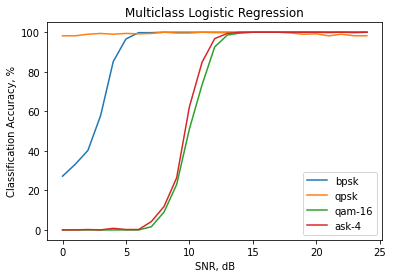

In [25]:
plt.plot(snrs, bpsk_results)
plt.plot(snrs, qpsk_results)
plt.plot(snrs, qam_results)
plt.plot(snrs, ask4_results)
plt.legend(('bpsk', 'qpsk', 'qam-16', 'ask-4'))
plt.ylabel('Classification Accuracy, %')
plt.xlabel('SNR, dB')
plt.title('Multiclass Logistic Regression')
plt.show()

**Confusion matrix**

Similarly, we can plot a new confusion matrix for our learned classifier.

In [26]:
# Set test parameters
snr = 15
num_symbols = 128
num_examples = 100

# Produce the test data
bpsk_test = np.array([generate_bpsk(num_symbols,snr) for i in range(num_examples)])
qpsk_test = np.array([generate_qpsk(num_symbols,snr) for i in range(num_examples)])
qam_test = np.array([generate_qam(num_symbols,snr) for i in range(num_examples)])
ask4_test = np.array([generate_ask4(num_symbols,snr) for i in range(num_examples)])

# Get results in one-hot encoding form
bpsk_predictions = to_onehot(np.argmax([predict_multiclass(x, h) for x in np.array([calculate_statistics(x) for x in bpsk_test])],axis=1),num_classes=4)
qpsk_predictions = to_onehot(np.argmax([predict_multiclass(x, h) for x in np.array([calculate_statistics(x) for x in qpsk_test])],axis=1),num_classes=4)
qam_predictions = to_onehot(np.argmax([predict_multiclass(x, h) for x in np.array([calculate_statistics(x) for x in qam_test])],axis=1),num_classes=4)
ask4_predictions = to_onehot(np.argmax([predict_multiclass(x, h) for x in np.array([calculate_statistics(x) for x in ask4_test])],axis=1),num_classes=4)

# Stack results to form a confusion matrix
cm_new = np.vstack((np.sum(bpsk_predictions,axis=0), np.sum(qpsk_predictions,axis=0), np.sum(qam_predictions,axis=0), np.sum(ask4_predictions,axis=0)))

Plotting the confusion matrix at the same SNR of 15dB, we can see a much cleaner diagonal than in the previous notebook. The confusion between QPSK and 16-QAM is minimzed, likely due to the learned classifier taking advantage of more features than our basic DT implementation.

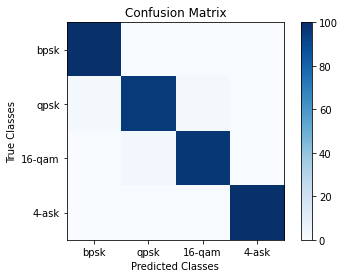

In [27]:
plt.imshow(cm_new, cmap='Blues')
plt.xticks([0,1,2,3], ['bpsk', 'qpsk', '16-qam', '4-ask'])
plt.yticks([0,1,2,3], ['bpsk', 'qpsk', '16-qam', '4-ask'])
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.colorbar()

## 2.5 Conclusion <a class="anchor" id="conclusion"></a>

Here we saw how to improve the results of a manually coded DT classifier by using machine learning and training a logistic regression classifier using simulated data. One of the biggest advantages of approach our problem this way is that we do not have to manually tune individual threshold values for our statistical features, and can just let the model learn these on its own. Ofcourse this comes with the tradeoff of coming up with a good dataset and tuning the training parameters - however as numbers of features and complexity increase, human effort increases drastically and we might be better off scaling with machine learning.

The basic principle of training a model using supervised learning that we covered here will persist in even the most advanced machine learning applications. A Deep Learning approach would look very similar, except typically we would not even provide the model the statistical features we computed, as it would be able to figure out the best features to use out of the raw samples (at least in theory).

[⬅️ Previous Notebook](01_modulation_classification.ipynb)

----
----